In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(123)

## Dataset Instructions:

- You need to download the dataset from here: https://ai.stanford.edu/~amaas/data/sentiment/
- Then, you need to unzip the downloaded zipped file in the present working directory
- That should result in a new folder named aclImdb under the present working directory

In [4]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████| 12500/12500 [00:00<00:00, 14500.84it/s]

Number of reviews : 25000


In [3]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# accumulate all review texts together
reviews_blob = ' '.join(review_list)

# generate list of all words of all reviews
review_words = reviews_blob.split()

# get the word counts
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|██████████| 25000/25000 [00:01<00:00, 13231.57it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [4]:
# create word to integer (token) dictionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [5]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])

for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt

[15, 3, 17, 11, 201, 56, 1165, 47, 242, 23, 3, 168, 4, 891, 4325, 3513, 15, 10, 1514, 822, 3, 17, 112, 884, 14623, 6, 155, 161, 7307, 15816, 6, 3, 134, 20049, 1, 32064, 108, 6, 33, 1492, 1943, 103, 15, 1550, 1, 18993, 9055, 1809, 14, 3, 549, 6906]


In [6]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

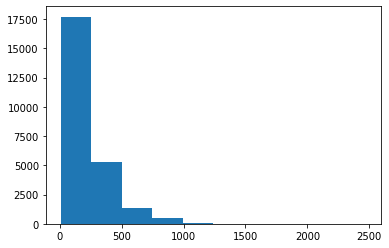

In [7]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len);

In [8]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [ ]:
## If while training, you get a runtime error that says: "RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long".
## simply uncomment run the following lines of code additionally
# train_X = train_X.astype('int64')
# train_y = train_y.astype('int64')
# validation_X = validation_X.astype('int64')
# validation_y = validation_y.astype('int64')

In [9]:
# generate torch datasets
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))


batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = train_data_iter.next()
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,     1,   875,   520],
        [    0,     0,     0,  ...,   482,   800,  1794],
        [    0,     0,     0,  ...,     3,  1285, 70251],
        ...,
        [    0,     0,     0,  ...,     4,     1,  1374],
        [    0,     0,     0,  ...,     2,  8268, 17117],
        [    0,     0,     0,  ...,  6429,   271,   116]])

Example Output size:  torch.Size([32])
Example Output:
 tensor([1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])


In [11]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)  
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [12]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

In [13]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [14]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [15]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 136.13723397254944s
training loss: 0.627 | training accuracy: 66.23%
validation loss: 1.048 |  validation accuracy: 19.65%

epoch number: 2 | time elapsed: 150.36637210845947s
training loss: 0.533 | training accuracy: 73.80%
validation loss: 0.858 |  validation accuracy: 54.43%

epoch number: 3 | time elapsed: 186.54570603370667s
training loss: 0.438 | training accuracy: 80.39%
validation loss: 0.551 |  validation accuracy: 78.56%

epoch number: 4 | time elapsed: 178.38556694984436s
training loss: 0.383 | training accuracy: 83.26%
validation loss: 0.915 |  validation accuracy: 57.72%

epoch number: 5 | time elapsed: 184.10346102714539s
training loss: 0.334 | training accuracy: 86.46%
validation loss: 1.001 |  validation accuracy: 56.94%

epoch number: 6 | time elapsed: 180.75322008132935s
training loss: 0.299 | training accuracy: 88.33%
validation loss: 1.164 |  validation accuracy: 54.97%

epoch number: 7 | time elapsed: 189.0122902393341s
training loss

In [16]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

In [20]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I loved the movie, every part of it"))

0.05216024070978165
0.17682921886444092
0.7510029077529907
0.9689022898674011
0.9829260110855103
